# Unsupervised Machine Learning: Clustering

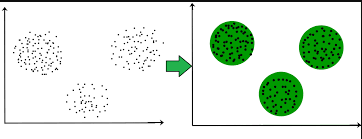

In [22]:
import threadpoolctl                                # Gerenciamento de controladores para a execução paralela de threads
import pandas as pd                                 # type: ignore # Importa a biblioteca pandas para manipulação de dados
import numpy as np                                  # type: ignore # Importa a biblioteca numpy para operações numéricas
import matplotlib.pyplot as plt                     # type: ignore # Importa a biblioteca matplotlib para visualização gráfica
import seaborn as sns                               # type: ignore # Importa a biblioteca seaborn para gráficos estatísticos
import scipy.cluster.hierarchy as sch               # type: ignore # Importa o módulo de hierarquia de clusters do scipy
import scipy.stats as stats                         # type: ignore # Importa o módulo de estatísticas do scipy
from scipy.stats import zscore                      # type: ignore # Importa a função zscore para normalização
from scipy.spatial.distance import pdist            # type: ignore # Importa a função pdist para calcular distâncias
from sklearn.cluster import AgglomerativeClustering # type: ignore # Importa o algoritmo de clustering hierárquico aglomerativo
from sklearn.cluster import KMeans                  # type: ignore # Importa o algoritmo KMeans para clustering
from sklearn.metrics import silhouette_score        # type: ignore # Importa a função para calcular o índice de silhueta
import pingouin as pg                               # type: ignore # Importa a biblioteca pingouin para análise estatística avançada
import plotly.express as px                         # type: ignore # Importa a biblioteca plotly.express para gráficos interativos
import plotly.io as pio                             # type: ignore # Importa a biblioteca plotly.io para configuração de renderização de gráficos
pio.renderers.default = 'browser'                   # Define o navegador como o renderizador padrão para gráficos plotly

In [23]:
dados_cartao = pd.read_csv('cartao_credito.csv')

In [24]:
dados_cartao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [25]:
dados_cartao.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [46]:
novos_nomes = {
    'Sl_No': 'N_Serie',
    'Customer Key': 'Chave_Cliente',
    'Avg_Credit_Limit': 'Limite_Credito_Medio',
    'Total_Credit_Cards': 'Total_Cartoes_Credito',
    'Total_visits_bank': 'Visitas_Banco',
    'Total_visits_online': 'Visitas_Online',
    'Total_calls_made': 'Total_Chamadas'
}
# Renomear as colunas do DataFrame
dados_cartao.rename(columns=novos_nomes, inplace=True)

In [47]:
dados_cartao

,N_Serie,Chave_Cliente,Limite_Credito_Medio,Total_Cartoes_Credito,Visitas_Banco,Visitas_Online,Total_Chamadas
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
...,...,...,...,...,...,...,...
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0


In [49]:
# Calcula estatísticas descritivas para o DataFrame 'cartao_cluster' e transpõe o resultado
# A função describe() retorna estatísticas descritivas como média, desvio padrão, valores mínimo e máximo
# .T transpõe o DataFrame para que as estatísticas sejam apresentadas em linhas em vez de colunas
tab_descritivas = dados_cartao.drop(columns=['N_Serie', 'Chave_Cliente']).describe().T
tab_descritivas

,count,mean,std,min,25%,50%,75%,max
Limite_Credito_Medio,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Cartoes_Credito,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Visitas_Banco,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Visitas_Online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_Chamadas,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


In [50]:
# Aplica a normalização Z-score em cada coluna do DataFrame 'cartao_cluster'
# A função zscore da biblioteca scipy.stats é utilizada para normalizar os dados
# ddof=1 especifica que a normalização deve usar o desvio padrão amostral (n-1)
cartao_pad = dados_cartao.drop(columns=['N_Serie', 'Chave_Cliente']).apply(zscore, ddof=1)
cartao_pad

,Limite_Credito_Medio,Total_Cartoes_Credito,Visitas_Banco,Visitas_Online,Total_Chamadas
0,1.738868,-1.248278,-0.859799,-0.547075,-1.250589
1,0.409982,-0.786988,-1.472614,2.518608,1.890425
2,0.409982,1.058171,-0.859799,0.134188,0.145417
3,-0.121573,0.135591,-0.859799,-0.547075,0.145417
4,1.738868,0.596881,-1.472614,3.199871,-0.203584
...,...,...,...,...,...
655,1.712290,2.442040,-0.859799,2.518608,-1.250589
656,1.313624,2.442040,-0.859799,3.540503,-0.552586
657,2.934866,1.519460,-0.859799,2.177977,-0.901587
658,3.652464,2.442040,-0.859799,4.221766,-1.250589


Essa normalização é importante em técnicas de clustering e outras análises, pois ajuda a garantir que todas as variáveis contribuam igualmente para os cálculos, eliminando a influência de escalas diferentes.

In [51]:
# Calcula a média das colunas no DataFrame 'cartao_pad' e arredonda os valores para 3 casas decimais
# A média deve ser próxima de 0 após a normalização Z-score
print(round(cartao_pad.mean(), 3))

# Calcula o desvio padrão das colunas no DataFrame 'cartao_pad' e arredonda os valores para 3 casas decimais
# O desvio padrão deve ser próximo de 1 após a normalização Z-score
print(round(cartao_pad.std(), 3))

Limite_Credito_Medio     0.0
Total_Cartoes_Credito    0.0
Visitas_Banco            0.0
Visitas_Online           0.0
Total_Chamadas          -0.0
dtype: float64
Limite_Credito_Medio     1.0
Total_Cartoes_Credito    1.0
Visitas_Banco            1.0
Visitas_Online           1.0
Total_Chamadas           1.0
dtype: float64


In [53]:
# Cria um gráfico de dispersão 3D usando a biblioteca plotly.express
# 'cartao_pad' é o DataFrame com os dados normalizados
# Define as variáveis para os eixos x, y e z do gráfico 3D
fig = px.scatter_3d(cartao_pad,
                    x='Limite_Credito_Medio',    # Variável para o eixo x
                    y='Total_Cartoes_Credito',  # Variável para o eixo y
                    z='Visitas_Banco')   # Variável para o eixo z

# Exibe o gráfico 3D interativo
fig.show()


In [54]:
# Cria uma lista para armazenar os valores da inércia do KMeans para diferentes números de clusters
elbow = []
# Define o intervalo de números de clusters a serem testados
k = range(1, 11)
# Loop para aplicar o KMeans para cada número de clusters
for line in k:
    # Inicializa o KMeans com o número atual de clusters e ajusta o modelo aos dados normalizados
    kmeanElbow = KMeans(n_clusters=line, init='random', random_state=100).fit(cartao_pad)
    # Adiciona o valor da inércia (soma das distâncias quadradas dos pontos aos seus centróides) à lista 'elbow'
    elbow.append(kmeanElbow.inertia_)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

Comentários adicionais:

* Inércia: 

    É a soma das distâncias quadradas dos pontos aos seus centróides. 

    Em geral, quanto menor a inércia, melhor o ajuste do modelo, mas também é importante evitar o sobreajuste.
    

* Método do Codo (Elbow Method): 

    Este código está preparando dados para o método do cotovelo, que ajuda a determinar o número ótimo de clusters testando a inércia para diferentes números de clusters e identificando onde a taxa de diminuição da inércia começa a diminuir mais lentamente.

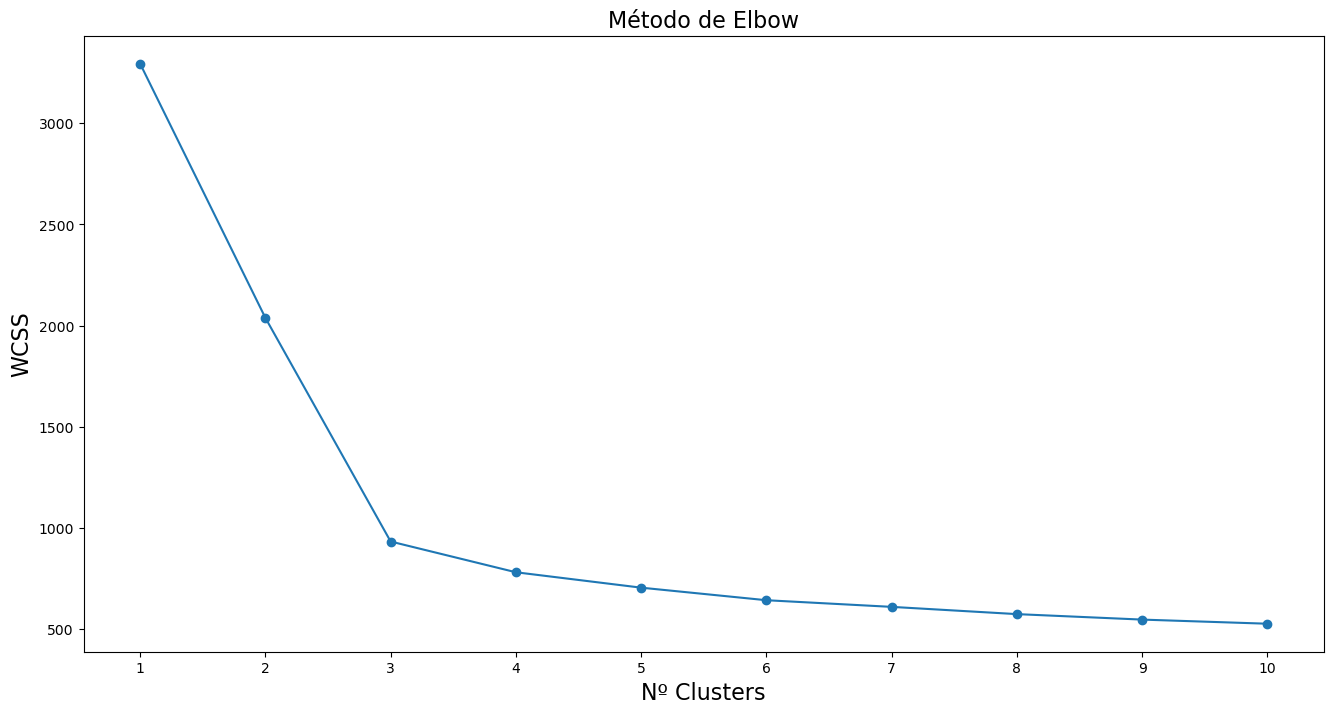

In [55]:
# Cria uma nova figura para o gráfico com tamanho 16x8 polegadas
plt.figure(figsize=(16, 8))
# Plota o gráfico da inércia para diferentes números de clusters, marcando os pontos com 'o'
plt.plot(k, elbow, marker='o')
# Define o rótulo do eixo x e o tamanho da fonte
plt.xlabel('Nº Clusters', fontsize=16)
# Define os ticks do eixo x para o intervalo de 1 a 10
plt.xticks(range(1, 11))  # ajustar range
# Define o rótulo do eixo y e o tamanho da fonte
plt.ylabel('WCSS', fontsize=16)  # WCSS significa Within-Cluster Sum of Squares
# Define o título do gráfico e o tamanho da fonte
plt.title('Método de Elbow', fontsize=16)
# Exibe o gráfico
plt.show()

In [56]:
# Vamos considerar 3 clusters, considerando as evidências anteriores!

# Inicializando e ajustando o modelo KMeans
# n_clusters: número de clusters que queremos formar, neste caso 3
# init: método de inicialização dos centróides, neste caso 'random' (aleatório)
# random_state: semente para gerar resultados reproduzíveis
# fit: ajusta o modelo aos dados fornecidos (cartao_pad)
kmeans_final = KMeans(n_clusters=3, init='random', random_state=100).fit(cartao_pad)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



In [58]:
# Gerando a variável para identificarmos os clusters gerados

kmeans_clusters = kmeans_final.labels_                                                  # Obtendo os rótulos dos clusters formados pelo modelo KMeans
dados_cartao['cluster_kmeans'] = kmeans_clusters                                        # Adicionando os rótulos dos clusters ao DataFrame cartao_cluster em uma nova coluna 'cluster_kmeans'
cartao_pad['cluster_kmeans'] = kmeans_clusters                                          # Adicionando os rótulos dos clusters ao DataFrame cartao_pad em uma nova coluna 'cluster_kmeans'
dados_cartao['cluster_kmeans'] = dados_cartao['cluster_kmeans'].astype('category')      # Convertendo a coluna 'cluster_kmeans' do DataFrame cartao_cluster para o tipo 'category'
cartao_pad['cluster_kmeans'] = cartao_pad['cluster_kmeans'].astype('category')          # Convertendo a coluna 'cluster_kmeans' do DataFrame cartao_pad para o tipo 'category'

In [35]:
## cluster_kmeans MS: indica a variabilidade entre grupos
## Within MS: indica a variabilidade dentro dos grupos
## F: estatística de teste (cluster_kmeans MS / Within MS)
## p-unc: p-valor da estatística F
## se p-valor < 0.05: pelo menos um cluster apresenta média estatisticamente diferente dos demais

In [60]:
dados_cartao.columns

Index(['N_Serie', 'Chave_Cliente', 'Limite_Credito_Medio',
       'Total_Cartoes_Credito', 'Visitas_Banco', 'Visitas_Online',
       'Total_Chamadas', 'cluster_kmeans'],
      dtype='object')

In [62]:
# Avg_Credit_Limit

# Executando uma ANOVA (Análise de Variância) usando a biblioteca Pingouin
# dv: a variável dependente, neste caso 'Avg_Credit_Limit'
# between: o fator entre os grupos, neste caso 'cluster_kmeans'
# data: o DataFrame que contém os dados, neste caso 'cartao_pad'
# detailed: se True, retorna um resultado mais detalhado
# T: transpor o DataFrame resultante para uma visualização mais legível
anova_results = pg.anova(dv='Limite_Credito_Medio', 
                         between='cluster_kmeans', 
                         data=cartao_pad,
                         detailed=True).T
anova_results

,0,1
Source,cluster_kmeans,Within
SS,479.901385,179.098615
DF,2,657
MS,239.950692,0.272601
F,880.227938,NaN
p-unc,0.0,NaN
np2,0.728227,NaN


In [63]:
# Total_Credit_Cards

# Executando uma ANOVA (Análise de Variância) usando a biblioteca Pingouin
# dv: a variável dependente, neste caso 'Total_Credit_Cards'
# between: o fator entre os grupos, neste caso 'cluster_kmeans'
# data: o DataFrame que contém os dados, neste caso 'cartao_pad'
# detailed: se True, retorna um resultado mais detalhado
# T: transpor o DataFrame resultante para uma visualização mais legível
anova_results = pg.anova(dv='Total_Cartoes_Credito', 
                         between='cluster_kmeans', 
                         data=cartao_pad,
                         detailed=True).T
anova_results

,0,1
Source,cluster_kmeans,Within
SS,478.078715,180.921285
DF,2,657
MS,239.039358,0.275375
F,868.050755,NaN
p-unc,0.0,NaN
np2,0.725461,NaN


In [64]:
# Total_visits_bank

# Executando uma ANOVA (Análise de Variância) usando a biblioteca Pingouin
# dv: a variável dependente, neste caso 'Total_visits_bank'
# between: o fator entre os grupos, neste caso 'cluster_kmeans'
# data: o DataFrame que contém os dados, neste caso 'cartao_pad'
# detailed: se True, retorna um resultado mais detalhado
# T: transpor o DataFrame resultante para uma visualização mais legível
anova_results = pg.anova(dv='Visitas_Banco', 
                         between='cluster_kmeans', 
                         data=cartao_pad,
                         detailed=True).T
anova_results

,0,1
Source,cluster_kmeans,Within
SS,413.975651,245.024349
DF,2,657
MS,206.987826,0.372944
F,555.010154,NaN
p-unc,0.0,NaN
np2,0.628188,NaN


In [65]:
# Total_visits_online

# Executando uma ANOVA (Análise de Variância) usando a biblioteca Pingouin
# dv: a variável dependente, neste caso 'Total_visits_online'
# between: o fator entre os grupos, neste caso 'cluster_kmeans'
# data: o DataFrame que contém os dados, neste caso 'cartao_pad'
# detailed: se True, retorna um resultado mais detalhado
# T: transpor o DataFrame resultante para uma visualização mais legível
anova_results = pg.anova(dv='Visitas_Online', 
                         between='cluster_kmeans', 
                         data=cartao_pad,
                         detailed=True).T
anova_results

,0,1
Source,cluster_kmeans,Within
SS,540.564886,118.435114
DF,2,657
MS,270.282443,0.180267
F,1499.348962,NaN
p-unc,0.0,NaN
np2,0.820281,NaN


In [66]:
# Total_calls_made

# Executando uma ANOVA (Análise de Variância) usando a biblioteca Pingouin
# dv: a variável dependente, neste caso 'Total_calls_made'
# between: o fator entre os grupos, neste caso 'cluster_kmeans'
# data: o DataFrame que contém os dados, neste caso 'cartao_pad'
# detailed: se True, retorna um resultado mais detalhado
# T: transpor o DataFrame resultante para uma visualização mais legível
anova_results = pg.anova(dv='Total_Chamadas', 
                         between='cluster_kmeans', 
                         data=cartao_pad,
                         detailed=True).T
anova_results

,0,1
Source,cluster_kmeans,Within
SS,450.849316,208.150684
DF,2,657
MS,225.424658,0.31682
F,711.523007,NaN
p-unc,0.0,NaN
np2,0.684142,NaN


In [37]:
# Perspectiva 1

# Criando um gráfico de dispersão 3D usando Plotly Express
# cartao_cluster: o DataFrame que contém os dados
# x: a variável para o eixo X, neste caso 'Avg_Credit_Limit'
# y: a variável para o eixo Y, neste caso 'Total_Credit_Cards'
# z: a variável para o eixo Z, neste caso 'Total_visits_online'
# color: a variável que determina a cor dos pontos, neste caso 'cluster_kmeans'
fig = px.scatter_3d(carta, 
                    x='Avg_Credit_Limit', 
                    y='Total_Credit_Cards', 
                    z='Total_visits_online',
                    color='cluster_kmeans')

# Exibindo o gráfico
fig.show()


In [67]:
dados_cartao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   N_Serie                660 non-null    int64   
 1   Chave_Cliente          660 non-null    int64   
 2   Limite_Credito_Medio   660 non-null    int64   
 3   Total_Cartoes_Credito  660 non-null    int64   
 4   Visitas_Banco          660 non-null    int64   
 5   Visitas_Online         660 non-null    int64   
 6   Total_Chamadas         660 non-null    int64   
 7   cluster_kmeans         660 non-null    category
dtypes: category(1), int64(7)
memory usage: 37.0 KB


In [68]:
# Perspectiva 2

# Criando um gráfico de dispersão 3D usando Plotly Express
# dados_cartao: o DataFrame que contém os dados
# x: a variável para o eixo X, neste caso 'Limite_Credito_Medio'
# y: a variável para o eixo Y, neste caso 'Total_Cartoes_Credito'
# z: a variável para o eixo Z, neste caso 'Visitas_Banco'
# color: a variável que determina a cor dos pontos, neste caso 'cluster_kmeans'
fig = px.scatter_3d(dados_cartao, 
                    x='Limite_Credito_Medio', 
                    y='Total_Cartoes_Credito', 
                    z='Visitas_Banco',
                    color='Visitas_Online')

# Exibindo o gráfico
fig.show()


In [39]:
# Perspectiva 3

# Cria um gráfico de dispersão 3D usando a biblioteca Plotly Express
fig = px.scatter_3d(
    cartao_cluster,                  # DataFrame que contém os dados a serem plotados
    x='Avg_Credit_Limit',            # Coluna do DataFrame para o eixo x (limite de crédito médio)
    y='Total_Credit_Cards',          # Coluna do DataFrame para o eixo y (total de cartões de crédito)
    z='Total_calls_made',            # Coluna do DataFrame para o eixo z (total de chamadas feitas)
    color='cluster_kmeans'           # Coluna do DataFrame que determina a cor dos pontos (clusters do K-means)
)
# Exibe o gráfico 3D
fig.show()

In [40]:
# Agrupando o banco de dados

# Agrupa o DataFrame cartao_cluster com base na coluna 'cluster_kmeans'
# Isso cria um objeto GroupBy, que permite realizar operações de agregação ou transformação nos grupos
cartao_grupo = cartao_cluster.groupby(by=['cluster_kmeans'])


C:\Users\r2d2s\AppData\Local\Temp\ipykernel_10952\812276062.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [41]:
# Estatísticas descritivas por grupo
# Calcula estatísticas descritivas para cada grupo no DataFrame agrupado
# A função describe() gera estatísticas descritivas como média, desvio padrão, valores mínimos e máximos para cada coluna
# O método T transposta o DataFrame resultante, trocando linhas e colunas para facilitar a visualização
tab_desc_grupo = cartao_grupo.describe().T